# Credit Card Fraud Detection


Throughout the financial sector, machine learning algorithms are being developed to detect fraudulent transactions.  In this project, that is exactly what we are going to be doing as well.  Using a dataset of of nearly 28,500 credit card transactions and multiple unsupervised anomaly detection algorithms, we are going to identify transactions with a high probability of being credit card fraud.  In this project, we will build and deploy the following two machine learning algorithms:

* Local Outlier Factor (LOF)
* Isolation Forest Algorithm


In [1]:
import sys
import numpy
import pandas
import matplotlib
import seaborn
import scipy

print('Python: {}'.format(sys.version))
print('Numpy: {}'.format(numpy.__version__))
print('Pandas: {}'.format(pandas.__version__))
print('Matplotlib: {}'.format(matplotlib.__version__))
print('Seaborn: {}'.format(seaborn.__version__))
print('Scipy: {}'.format(scipy.__version__))


Python: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
Numpy: 1.14.3
Pandas: 0.23.0
Matplotlib: 2.2.2
Seaborn: 0.8.1
Scipy: 1.1.0


In [2]:
# import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### 2. The Data Set

We will begin exploring the dataset to gain an understanding of the type, quantity, and distribution of data in our dataset.  For this purpose, we will use Pandas' built-in describe feature, as well as parameter histograms and a correlation matrix. 

In [3]:
# Load the dataset from the csv file using pandas
data = pd.read_csv('creditcard.csv')

In [4]:
# Start exploring the dataset
print(data.columns)

#Class
#0 = a valid normal credit card transaction 
#1 = fraudulent transaction

Index([u'Time', u'V1', u'V2', u'V3', u'V4', u'V5', u'V6', u'V7', u'V8', u'V9',
       u'V10', u'V11', u'V12', u'V13', u'V14', u'V15', u'V16', u'V17', u'V18',
       u'V19', u'V20', u'V21', u'V22', u'V23', u'V24', u'V25', u'V26', u'V27',
       u'V28', u'Amount', u'Class'],
      dtype='object')


In [5]:
# Print the shape of the data
data = data.sample(frac=0.1, random_state = 1)
print(data.shape)
print(data.describe())

# V1 - V28 are the results of a PCA Dimensionality reduction 
#to protect user identities and sensitive features

(28481, 31)
                Time            V1            V2            V3            V4  \
count   28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean    94705.035216     -0.001143     -0.018290      0.000795      0.000350   
std     47584.727034      1.994661      1.709050      1.522313      1.420003   
min         0.000000    -40.470142    -63.344698    -31.813586     -5.266509   
25%     53924.000000     -0.908809     -0.610322     -0.892884     -0.847370   
50%     84551.000000      0.031139      0.051775      0.178943     -0.017692   
75%    139392.000000      1.320048      0.792685      1.035197      0.737312   
max    172784.000000      2.411499     17.418649      4.069865     16.715537   

                 V5            V6            V7            V8            V9  \
count  28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean      -0.015666      0.003634     -0.008523     -0.003040      0.014536   
std        1.395552      1.334

Since the mean is .001720, there are way more valid transactions then fraud ones

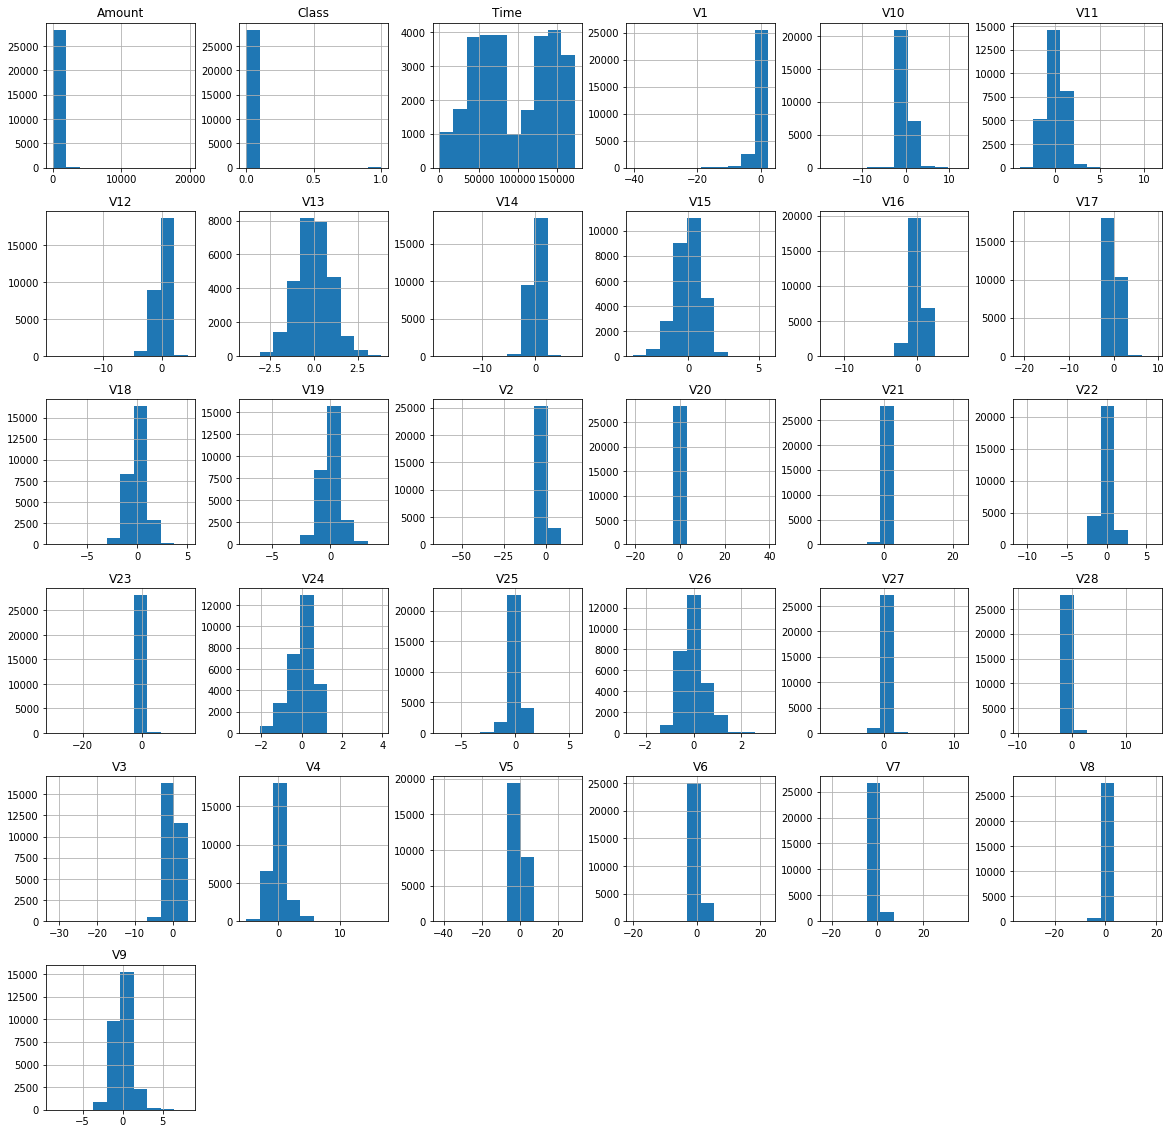

In [6]:
# Plot histograms of each parameter 
data.hist(figsize = (20, 20))
plt.show()

In [7]:
# Determine number of fraud cases in dataset

Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]

outlier_fraction = len(Fraud)/float(len(Valid))
#NOTE:# of fraud cases to valid cases. There is 1/10 cases are fraud
#use float so python does not round since value is so small
print(outlier_fraction)

print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))



0.0017304750013189597
Fraud Cases: 492
Valid Transactions: 284315


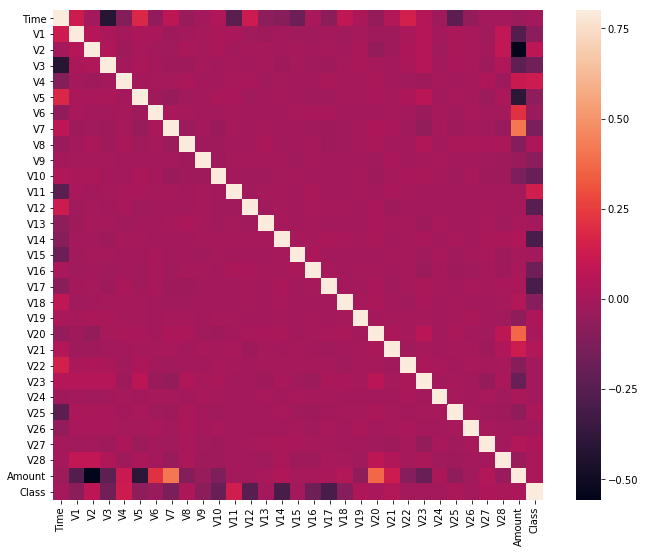

In [8]:
# Correlation matrix
corrmat = data.corr()
fig = plt.figure(figsize = (12, 9))

sns.heatmap(corrmat, vmax = .8, square = True)
plt.show()

Most values are really close to zero so there isn't strong relationships between our different V parameters. They are fairly unrelated to the others however what we do care about is the class. 

We see there's some variations in the relationships between the different parameters and our class 

V11 has a stronger positive whereas V17 would be a stronger negative correlation. There isn't a strong correlation between amount and whether or not it was fraudulent or time and whether or not it was fraudulent that could be some
interesting information to take away we don't see many one-to-one correlations here in in our correlation matrix so
that's good

We don't need to pull out any of our columns before we dive into doing our actual machine learning but before we actually get started with that we need to format our data set slightly so let's go ahead and do that

In [5]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want for modeling
columns = [c for c in columns if c not in ["Class"]]

# Store the variable we'll be predicting on
target = "Class"

X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(284807, 30)
(284807,)


## 3. Unsupervised Outlier Detection

Now that we have processed our data, we can begin deploying our machine learning algorithms.  We will use the following techniques: 

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a 
given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the 
object is with respect to the surrounding neighborhood. ()(Kmeans)


**Isolation Forest Algorithm**

The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting 
a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to 
isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees 
collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.(Random)

In [8]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# define random states
state = 1

# define outlier detection tools to be compared
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=state),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}
#20 is default, but the higher the percentage of outliers in your in your data set the
#higher you're going to want to make this number 

In [9]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)


for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))


Isolation Forest: 645
0.997735308472053
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.34      0.35      0.35       492

avg / total       1.00      1.00      1.00    284807

Local Outlier Factor: 935
0.9967170750718908
             precision    recall  f1-score   support

          0       1.00      1.00      1.00    284315
          1       0.05      0.05      0.05       492

avg / total       1.00      1.00      1.00    284807



<Figure size 648x504 with 0 Axes>

# In Eduonix tutorial, they used only 10% of the data for LOC and Isolation Forest Algorithm

Thier results were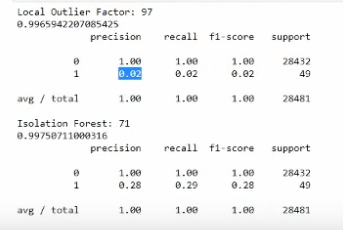